In [4]:
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# import tensorflow_probability as tfp
from tensorflow.keras import layers, Model, models, optimizers
from tensorflow import keras
# import tensorflow.keras.backend as K
#import shap
# import tensorflow_datasets as tfds2
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import itertools
import gc
from typing import Any, Callable, Iterable
from itertools import chain, combinations
import os
import json
import inspect
import shutil
tf.random.set_seed(1)
import matplotlib.cm as cm
import seaborn as sns

TensorFlow version: 2.18.1
Num GPUs Available:  0


# Data loading + Processing


In [3]:
DATA_DIR = "../data"
GENO_DIR = DATA_DIR
PHENO_DIR = DATA_DIR + "/pheno_data"
parental_geno_data = pd.read_csv(GENO_DIR + "/parent_genos_ordered.csv")
child_geno_data = pd.read_csv(GENO_DIR + "/all_child_genos_ordered.csv",
                               index_col=["pop", "individual"])
child_pheno_data = pd.read_csv(PHENO_DIR + "/pheno_oil_dist.csv",
                               index_col=["pop", "individual"])
shared_index = child_pheno_data.index.intersection(child_geno_data.index)
child_pheno_data = child_pheno_data.reindex(shared_index)
child_geno_data = child_geno_data.reindex(shared_index).reset_index()
parent_pheno_data = pd.read_csv(PHENO_DIR + "/parents_oil.csv")

p1_ids = child_geno_data['p1_id'].to_numpy()
p2_ids = child_geno_data['p2_id'].to_numpy()

# Parent 1 is technically always maize B73
# -> shuffle parent ids so model isnt fed same p1 input across all samples
p_genos_ids = np.stack([p1_ids, p2_ids], axis = 1)
#[np.random.shuffle(cur_sub) for cur_sub in p_genos_ids]

## Extract parent phenotypes
def extract_phenos(ids, parent_data, extract_col):
    res = []
    for cur_id in ids:
        row_bools = parent_data["p_id"] == cur_id
        res.append(parent_data.loc[row_bools, extract_col].to_numpy().flatten())
    return np.array(res)

## Extract parental phenos from pandas df
p1_phenos = extract_phenos(p_genos_ids[:, 0], parent_pheno_data, ["mean_value", "sd_value"])
p2_phenos = extract_phenos(p_genos_ids[:, 1], parent_pheno_data, ["mean_value", "sd_value"])
child_pheno_np = child_pheno_data[["val_mean", "val_sd"]].to_numpy()

## Stack parental phenotypes, split to oop and train + eval
parents_phenos = np.stack([p1_phenos, p2_phenos], axis=1)

all_geno_combs = list(itertools.product(["A", "T", "G", "C"], ["A", "T", "G", "C"])) + [("-", "-")]
all_geno_combs = np.unique(["".join(np.sort(cur_genos)) for cur_genos in all_geno_combs])

parental_geno_red = parental_geno_data.iloc[:, 1:]
p1_genos_np = extract_phenos(p_genos_ids[:, 0], parental_geno_red, parental_geno_red.columns[:-1])
p2_genos_np = extract_phenos(p_genos_ids[:, 1], parental_geno_red, parental_geno_red.columns[:-1])
p_genos_np = np.stack([p1_genos_np, p2_genos_np], axis = 1)


def one_hot_encode(data, vocab = all_geno_combs):
    encoded_list = [np.float16(data == cur_class) for cur_class in vocab]
    return tf.stack(encoded_list, axis = -1)

child_geno_tensor = one_hot_encode(child_geno_data.iloc[:, 2:-2].to_numpy())
p_genos_tensor = one_hot_encode(p_genos_np)


In [4]:
trait_c_scale = (child_pheno_data["val_mean"])/\
    (max(child_pheno_data["val_mean"]))
trait_c_scale = np.log(np.array(trait_c_scale))

In [5]:
pop_per_sample = child_geno_data["pop"]
pop_per_sample[pop_per_sample>17] = pop_per_sample[pop_per_sample>17] -1

/tmp/ipykernel_24666/1398655400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_per_sample[pop_per_sample>17] = pop_per_sample[pop_per_sample>17] -1


In [6]:
genos_tensor = tf.concat([
    p_genos_tensor,
    tf.expand_dims(child_geno_tensor, axis = 1)
    ], axis = 1)
phenos_tupel = (parents_phenos, child_pheno_np)

# Load Model

In [16]:
files_to_load = ["reg_vae_helpers.py", "cur_encoder.py", "cur_decoder.py",
    "geno_to_trait_model.py", "regression_vae.py"]
for cur_file in files_to_load:
    execfile("fav_model_16_02/" + cur_file)

/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [17]:
# for batch in train_dataset:
#     test_batch = batch
#     break
reg_vae_model = reg_vae(100, 5, 5)
# reg_vae_model.compile(run_eagerly = False)
_ = reg_vae_model.call((p_genos_tensor, parents_phenos))

building encoder


/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'decoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [18]:
reg_vae_model.load_weights("./fav_model_16_02/res_per_trait/results/oil/run3_best/model.weights.h5")

/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 270 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 354 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [19]:
# model_preds = reg_vae_model.call((one_hot_encode(tf.expand_dims(p2_genos_np, axis = 1)), parents_phenos))
# model_preds = reg_vae_model.call((tf.expand_dims(child_geno_tensor, axis = 1), parents_phenos))
full_model_preds = reg_vae_model.call((genos_tensor, parents_phenos))
full_embedding = full_model_preds[0]
p_model_preds = reg_vae_model.call((p_genos_tensor, parents_phenos))
p_embedding = p_model_preds[0]
c_model_preds = reg_vae_model.call((tf.expand_dims(child_geno_tensor, axis = 1), parents_phenos))
c_embedding = c_model_preds[0]
p2_model_preds = reg_vae_model.call(((one_hot_encode(tf.expand_dims(p2_genos_np, axis = 1))), parents_phenos))
p2_embedding = p2_model_preds[0]

# Load embeddings from Training

In [42]:
fit_folder = "fav_model_14_04/cp_encoders_per_latent_dim/latent_dim_exp_70_kl_01/cp_run_01"

In [43]:
full_embedding_df = pd.read_csv(fit_folder + "/pred_embed_test.csv")
full_trait_df = pd.read_csv(fit_folder + "/pred_embed_test.csv")
trait_df = pd.read_csv(fit_folder + "/pred_off_trait.csv").loc[:, ["true_mean", "true_sd", "pop", "sample_id"]]
trait_c_scale = (trait_df["true_mean"])/\
    (max(trait_df["true_mean"]))
full_embedding = full_embedding_df.to_numpy()[:, :-2]
pop_per_sample = full_embedding_df["pop"].to_numpy()

KeyError: "['true_mean', 'true_sd'] not in index"

# Embedding analysis

In [37]:
pca = PCA(n_components=2)
embeded_embedding = pca.fit_transform(full_embedding)

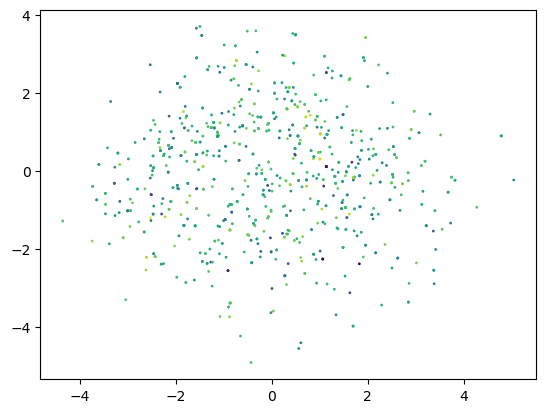

In [38]:
fig, axs = plt.subplots()
rand_idx = np.random.randint(0, embeded_embedding.shape[0], embeded_embedding.shape[0])
axs.scatter(embeded_embedding[rand_idx, 0], embeded_embedding[rand_idx, 1],
            s = 1, c= trait_c_scale[rand_idx])

## Umap

In [39]:
def draw_umap(data, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title='', c_maps=None):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = np.array(fit.fit_transform(data))
    rand_idx = np.random.randint(0, data.shape[0], data.shape[0])
    fig, axs = plt.subplots(1, len(c_maps), figsize=(15, 5))

    for i, c_map in enumerate(c_maps):
        if n_components == 1:
            ax = axs[i]
            ax.scatter(u[rand_idx,0], range(len(u)), s=10, c=c_map[rand_idx])
            ax.set_title(title, fontsize=18)
        if n_components == 2:
            ax = axs[i]
            ax.scatter(u[rand_idx,0], u[rand_idx,1], s=10, c=c_map[rand_idx])
            ax.set_title(title, fontsize=18)
        if n_components == 3:
            ax = axs[i]
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(u[rand_idx,0], u[rand_idx,1], u[:,2], s=10, c=c_map[rand_idx])
            ax.set_title(title, fontsize=18)
    plt.show()
    return u

/home/max/miniconda3/envs/tf-bb/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


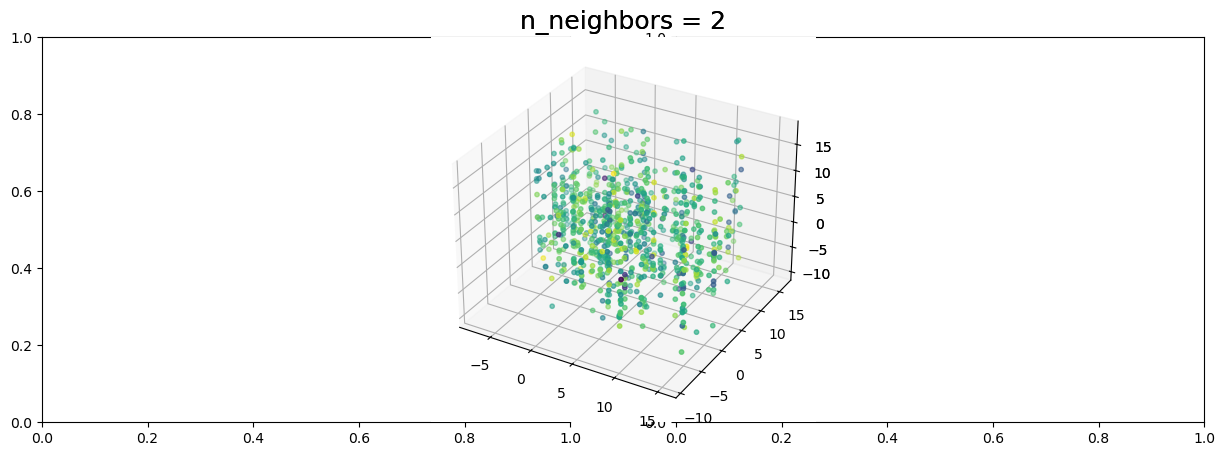

/home/max/miniconda3/envs/tf-bb/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


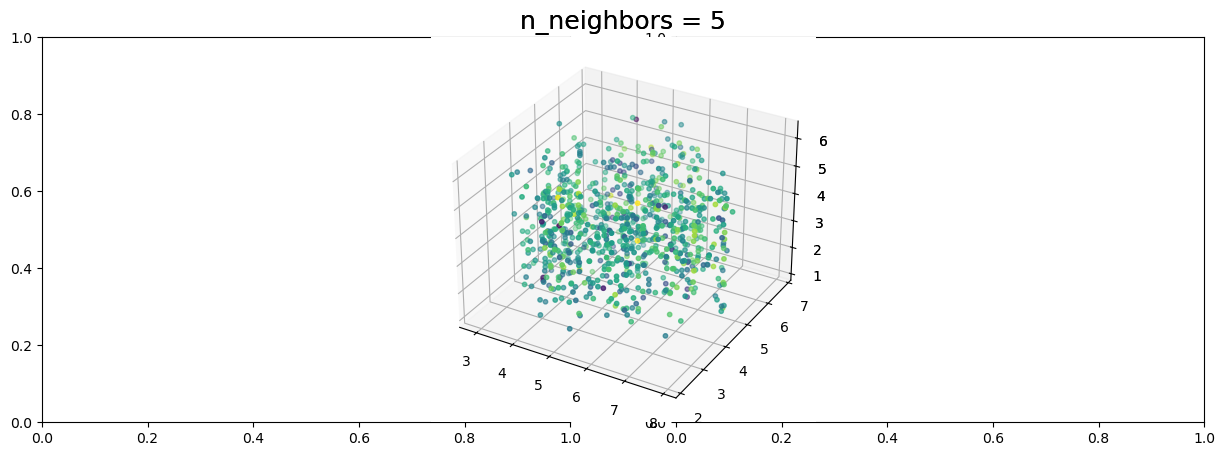

/home/max/miniconda3/envs/tf-bb/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


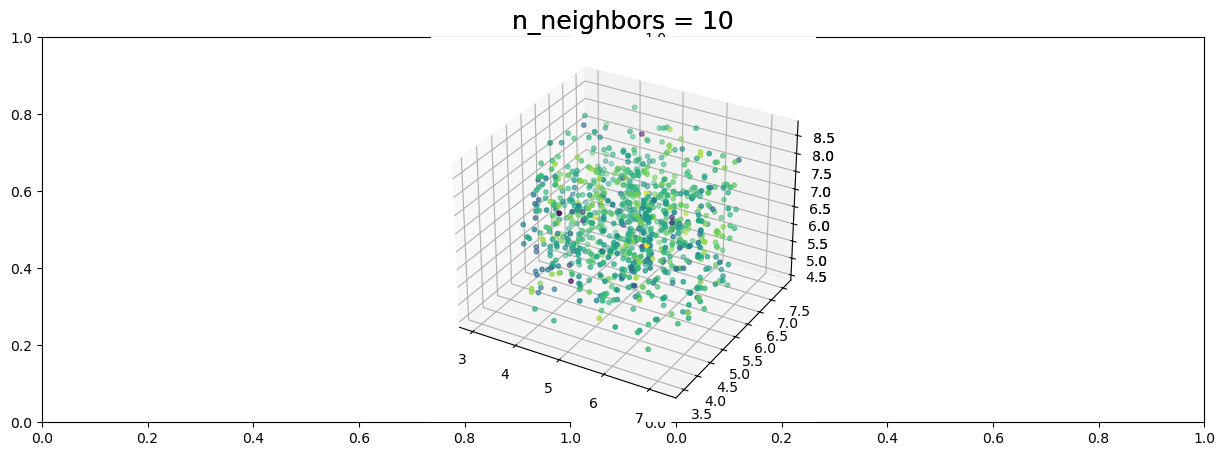

/home/max/miniconda3/envs/tf-bb/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


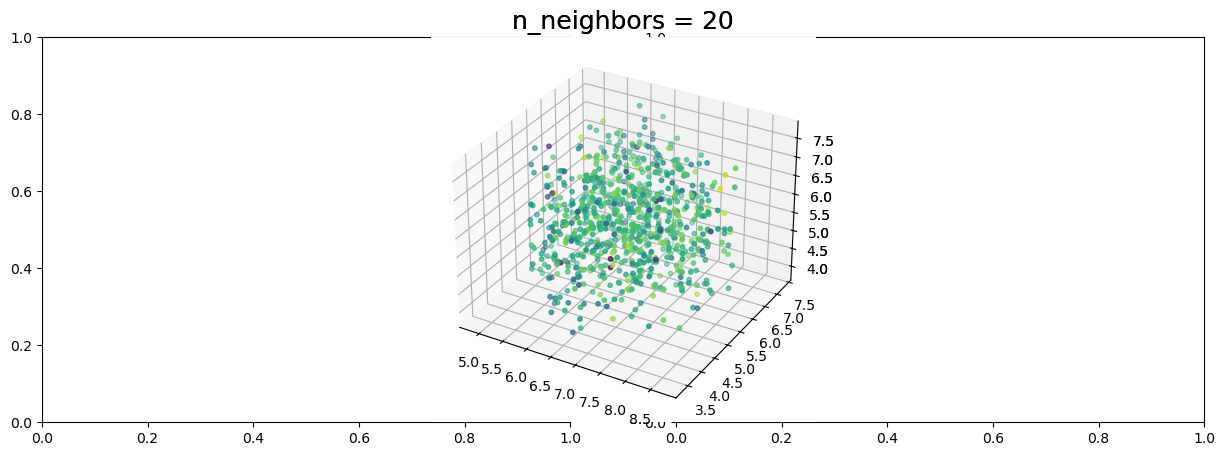

/home/max/miniconda3/envs/tf-bb/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


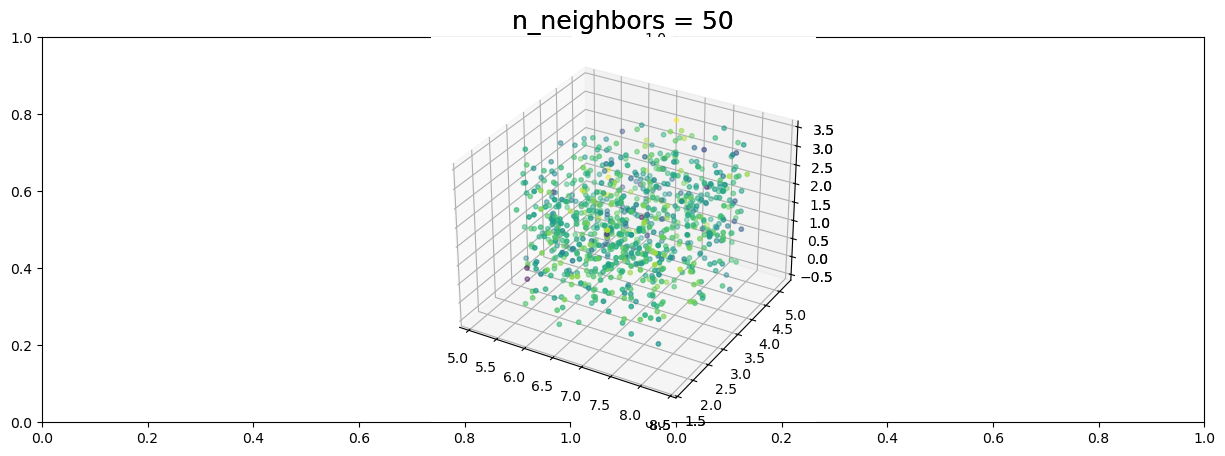

/home/max/miniconda3/envs/tf-bb/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


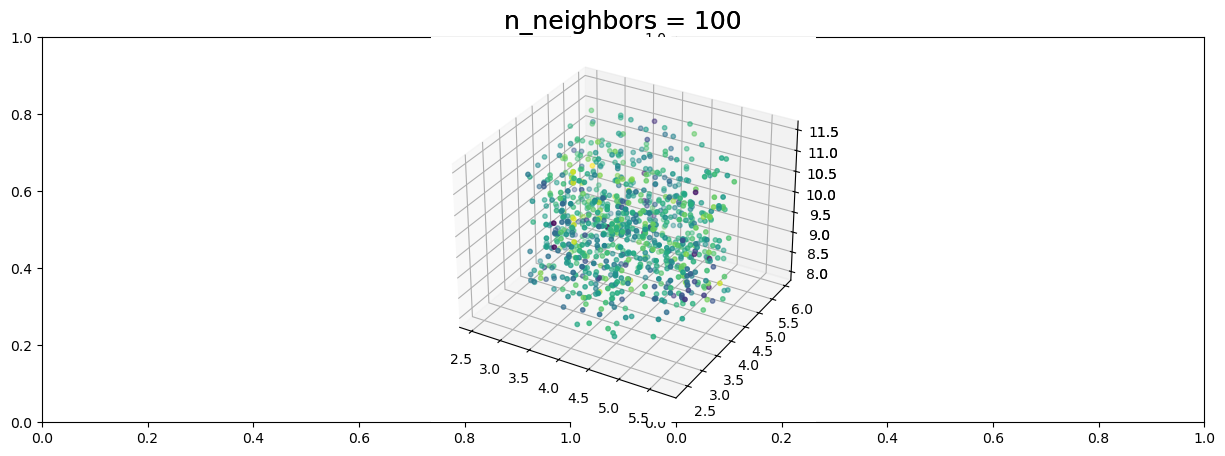

/home/max/miniconda3/envs/tf-bb/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


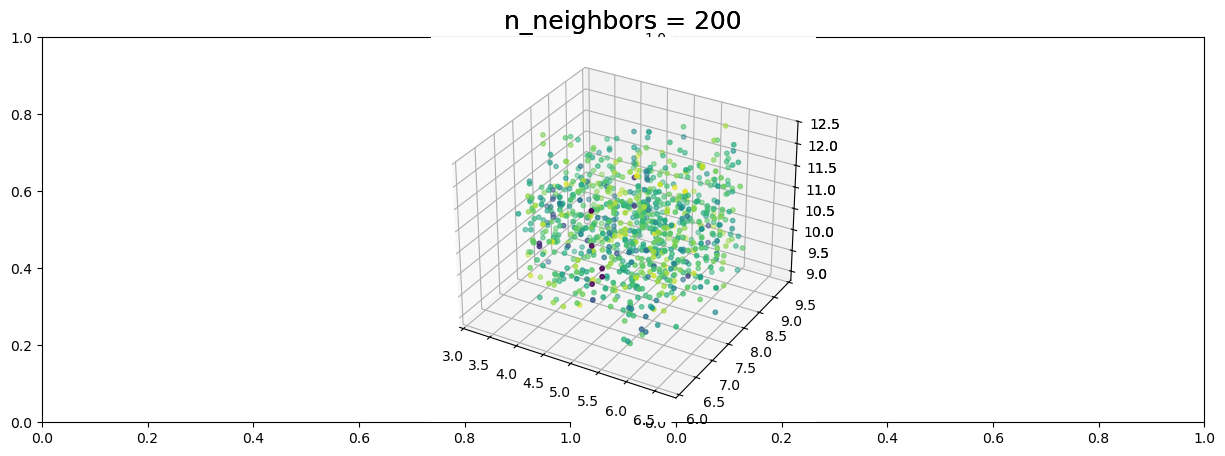

/home/max/miniconda3/envs/tf-bb/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


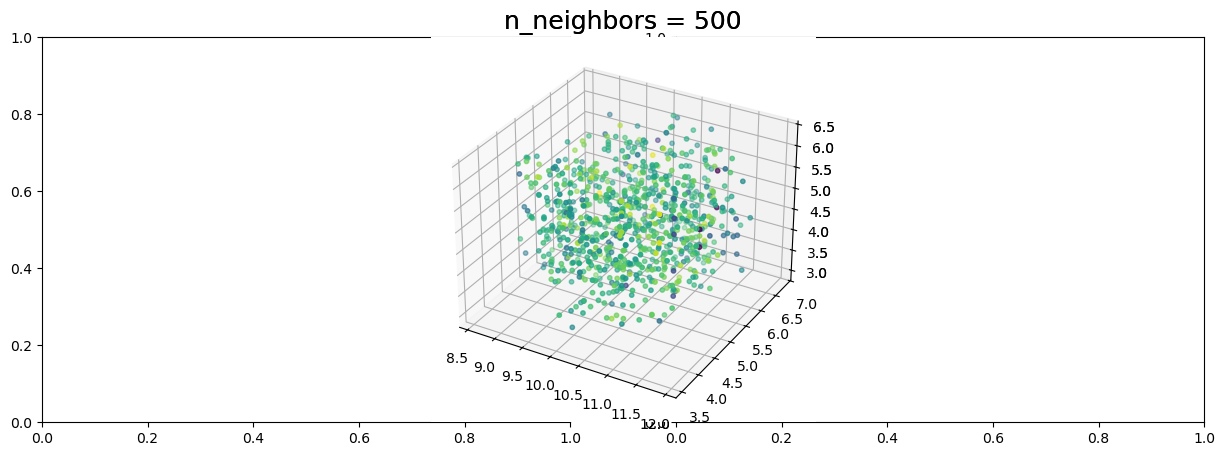

In [41]:
neighbor_options = (2, 5, 10, 20, 50, 100, 200, 500)
umap_embeddings = []
for n in neighbor_options:
    cur_embed = draw_umap(full_embedding, n_neighbors=n, title='n_neighbors = {}'.format(n),
              min_dist = 0.1, c_maps= [pop_per_sample, trait_c_scale], n_components = 3)
    umap_embeddings.append(cur_embed)

In [28]:
c_umap_embeddings = []
for n in neighbor_options:
    cur_embed = draw_umap(c_embedding, n_neighbors=n, title='n_neighbors = {}'.format(n),
              min_dist = 0.01, c_maps= [pop_per_sample, trait_c_scale], n_components = 2)
    c_umap_embeddings.append(cur_embed)

NameError: name 'c_embedding' is not defined

In [29]:
p2_umap_embeddings = []
for n in neighbor_options:
    cur_embed = draw_umap(p2_embedding, n_neighbors=n, title='n_neighbors = {}'.format(n),
              min_dist = 0.01, c_maps= [pop_per_sample, trait_c_scale], n_components = 2)
    p2_umap_embeddings.append(cur_embed)

NameError: name 'p2_embedding' is not defined

# T-Sne (as expected like umap)

In [76]:
from sklearn.manifold import TSNE
def draw_tsne(data, n_components=2, perplexity=30, metric='euclidean', title='', c_maps=None):
    fit = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        metric=metric
    )
    u = np.array(fit.fit_transform(data))
    rand_idx = np.random.randint(0, data.shape[0], data.shape[0])
    fig, axs = plt.subplots(1, len(c_maps), figsize=(15, 5))

    for i, c_map in enumerate(c_maps):
        if n_components == 1:
            ax = axs[i]
            ax.scatter(u[rand_idx,0], range(len(u)), s=10, c=c_map[rand_idx])
            ax.set_title(title, fontsize=18)
        if n_components == 2:
            ax = axs[i]
            ax.scatter(u[rand_idx,0], u[rand_idx,1], s=10, c=c_map[rand_idx])
            ax.set_title(title, fontsize=18)
        if n_components == 3:
            ax = axs[i]
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(u[rand_idx,0], u[rand_idx,1], u[:,2], s=10, c=c_map[rand_idx])
            ax.set_title(title, fontsize=18)
    plt.show()
    return u

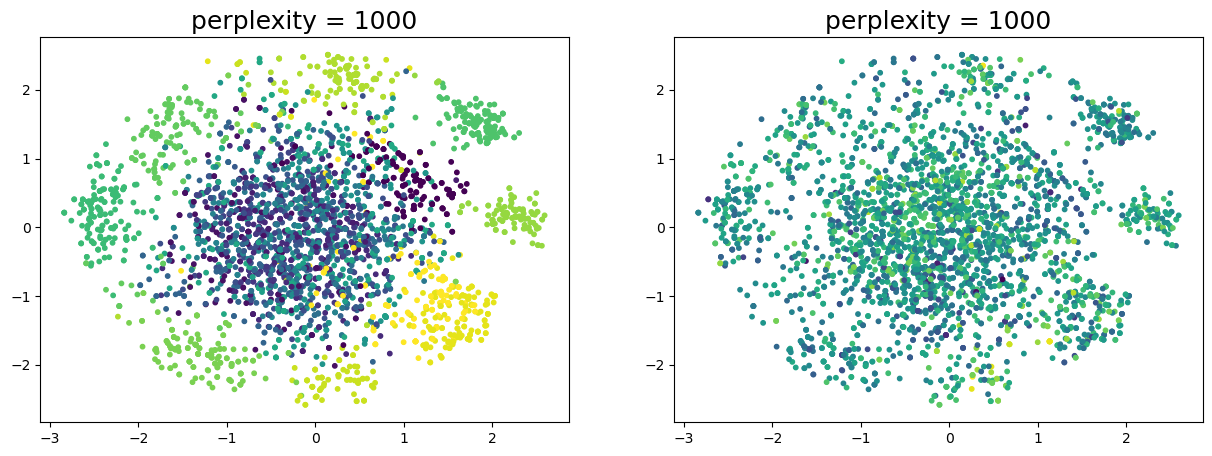

In [79]:
neighbor_options = [1000]
tsne_embeddings = []
for n in neighbor_options:
    cur_embed = draw_tsne(full_embedding, perplexity = n, n_components=2, title='perplexity = {}'.format(n),
              c_maps= [pop_per_sample, trait_c_scale])
    tsne_embeddings.append(cur_embed)

# Population given parents only

In [14]:
pop_preds = reg_vae_model.call((genos_tensor, parents_phenos))

In [15]:
def st_per_pop(data, op, sel_row = None, axis = 0):
    res = np.apply_along_axis(op, axis, data)
    if sel_row is not None:
        res = np.apply_along_axis(op, axis, data[sel_row, ...])
    return res

In [16]:
var_diff = []
for pop in np.unique(p2_ids):
    cur_var = st_per_pop(pop_preds[0].numpy(), np.var, sel_row= p2_ids == pop)
    var_diff.append(cur_var)

In [17]:
var_diff_df = pd.DataFrame(np.array(var_diff))
var_diff_df["pop"] = np.unique(p2_ids) - 1

In [ ]:
var_diff_df.to_csv("var_per_pop_oil.csv")

In [ ]:
embed_df = pd.DataFrame(pop_preds[0].numpy())
embed_df["pop"] = p2_ids

In [ ]:
embed_df.to_csv("embed_per_sample_oil.csv")

# Embedding clustering

In [89]:
# Compare silhouette values between train/test set
#   why better/worse clusters -> identify similar embedding regions in clusters
# Compare genotype distribution of good vs bad clusters, focus at p2
# Why good pop numbers consecutive @ silk?

In [90]:
trainset_per_sample = pd.read_csv("./fav_model_16_02/res_per_trait/results/protein/good_run/child_pheno_data.csv")
test_pop = np.unique(trainset_per_sample[trainset_per_sample["d_type"] == "test"]["pop"])
test_pop[test_pop > 17] = test_pop[test_pop > 17] -1
train_pop = np.unique(trainset_per_sample[trainset_per_sample["d_type"] == "train"]["pop"])
train_pop[train_pop > 17] = train_pop[train_pop > 17] -1

In [93]:
best_umap = 6
metrics.silhouette_score(umap_embeddings[best_umap], pop_per_sample)

np.float32(-0.0699134)

In [94]:
def get_sil_per_cluster(embedding, cluster_labels):
    sil_per_cluster = {}
    for cur_cluster in np.unique(cluster_labels):
        cluster_samples = np.asarray(cluster_labels == cur_cluster, dtype = int)
        score = metrics.silhouette_score(embedding, cluster_samples)
        sil_per_cluster[cur_cluster]= score
    return sil_per_cluster
sil_per_cluster_umap = get_sil_per_cluster(umap_embeddings[best_umap], pop_per_sample)
sil_per_cluster_full_embed = get_sil_per_cluster(full_embedding, pop_per_sample)

In [95]:
interesting_clusters_umap = [cluster_id for cluster_id in sil_per_cluster_umap.keys() if sil_per_cluster_umap[cluster_id] > 0]
interesting_clusters_full_embed = [cluster_id for cluster_id in sil_per_cluster_full_embed.keys() if sil_per_cluster_full_embed[cluster_id] > 0]

In [96]:
def draw_cluster(data, title='', c_maps=None, highlight_clusters=None):
    if c_maps is None:
        raise ValueError("c_maps must be provided as a list of cluster assignment arrays")
        
    np.random.seed(42)
    rand_idx = np.random.permutation(data.shape[0])
    u = data[rand_idx]

    fig, axs = plt.subplots(1, len(c_maps), figsize=(20, 10))
    if len(c_maps) == 1:
        axs = [axs]

    for cur_c_id, ax in enumerate(axs):
        current_c_map = c_maps[cur_c_id][rand_idx]
        unique_classes = np.unique(current_c_map)
        colors = cm.rainbow(np.linspace(0, 1, len(unique_classes)))

        current_highlights = []
        if highlight_clusters:
            if len(highlight_clusters) != len(c_maps):
                raise ValueError("highlight_clusters must match c_maps length")
            current_highlights = highlight_clusters[cur_c_id]

        # Plot regular clusters
        regular_clusters = [c for c in unique_classes if c not in current_highlights]
        for cluster in regular_clusters:
            mask = current_c_map == cluster
            color_idx = np.where(unique_classes == cluster)[0][0]
            ax.scatter(u[mask, 0], u[mask, 1], s=15, c=[colors[color_idx]], 
                      edgecolor='none', alpha=0.7, zorder=1)

        # Plot highlighted clusters
        emphasized_clusters = [c for c in unique_classes if c in current_highlights]
        for cluster in emphasized_clusters:
            mask = current_c_map == cluster
            color_idx = np.where(unique_classes == cluster)[0][0]
            ax.scatter(u[mask, 0], u[mask, 1], s=100, c=[colors[color_idx]],
                      edgecolor='black', linewidth=2, zorder=2)
            x_centroid = np.median(u[mask, 0])
            y_centroid = np.median(u[mask, 1])
            ax.text(x_centroid, y_centroid, str(cluster),
                    fontsize=12, weight='bold', ha='center', va='center',
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round'),
                    zorder=3)

        # Add text labels at cluster centroids
        for cluster in unique_classes:
            mask = current_c_map == cluster
            if np.sum(mask) > 0:  # Only label clusters with members
                pass

        ax.set_title(f'{title} - Method {cur_c_id+1}', fontsize=16)
        ax.set_xlabel('Component 1', fontsize=12)
        ax.set_ylabel('Component 2', fontsize=12)
        ax.legend(title='Cluster IDs', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

In [97]:
from sklearn import cluster
from sklearn import mixture

kmeans_clusters = cluster.SpectralClustering(n_clusters = 11, assign_labels = "kmeans").fit(umap_embeddings[best_umap])
# kmeans_clusters = cluster.KMeans(n_clusters = len(interesting_clusters)).fit(umap_embeddings[best_umap])

/tmp/ipykernel_891/3874845752.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Cluster IDs', bbox_to_anchor=(1.05, 1), loc='upper left')
/tmp/ipykernel_891/3874845752.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Cluster IDs', bbox_to_anchor=(1.05, 1), loc='upper left')


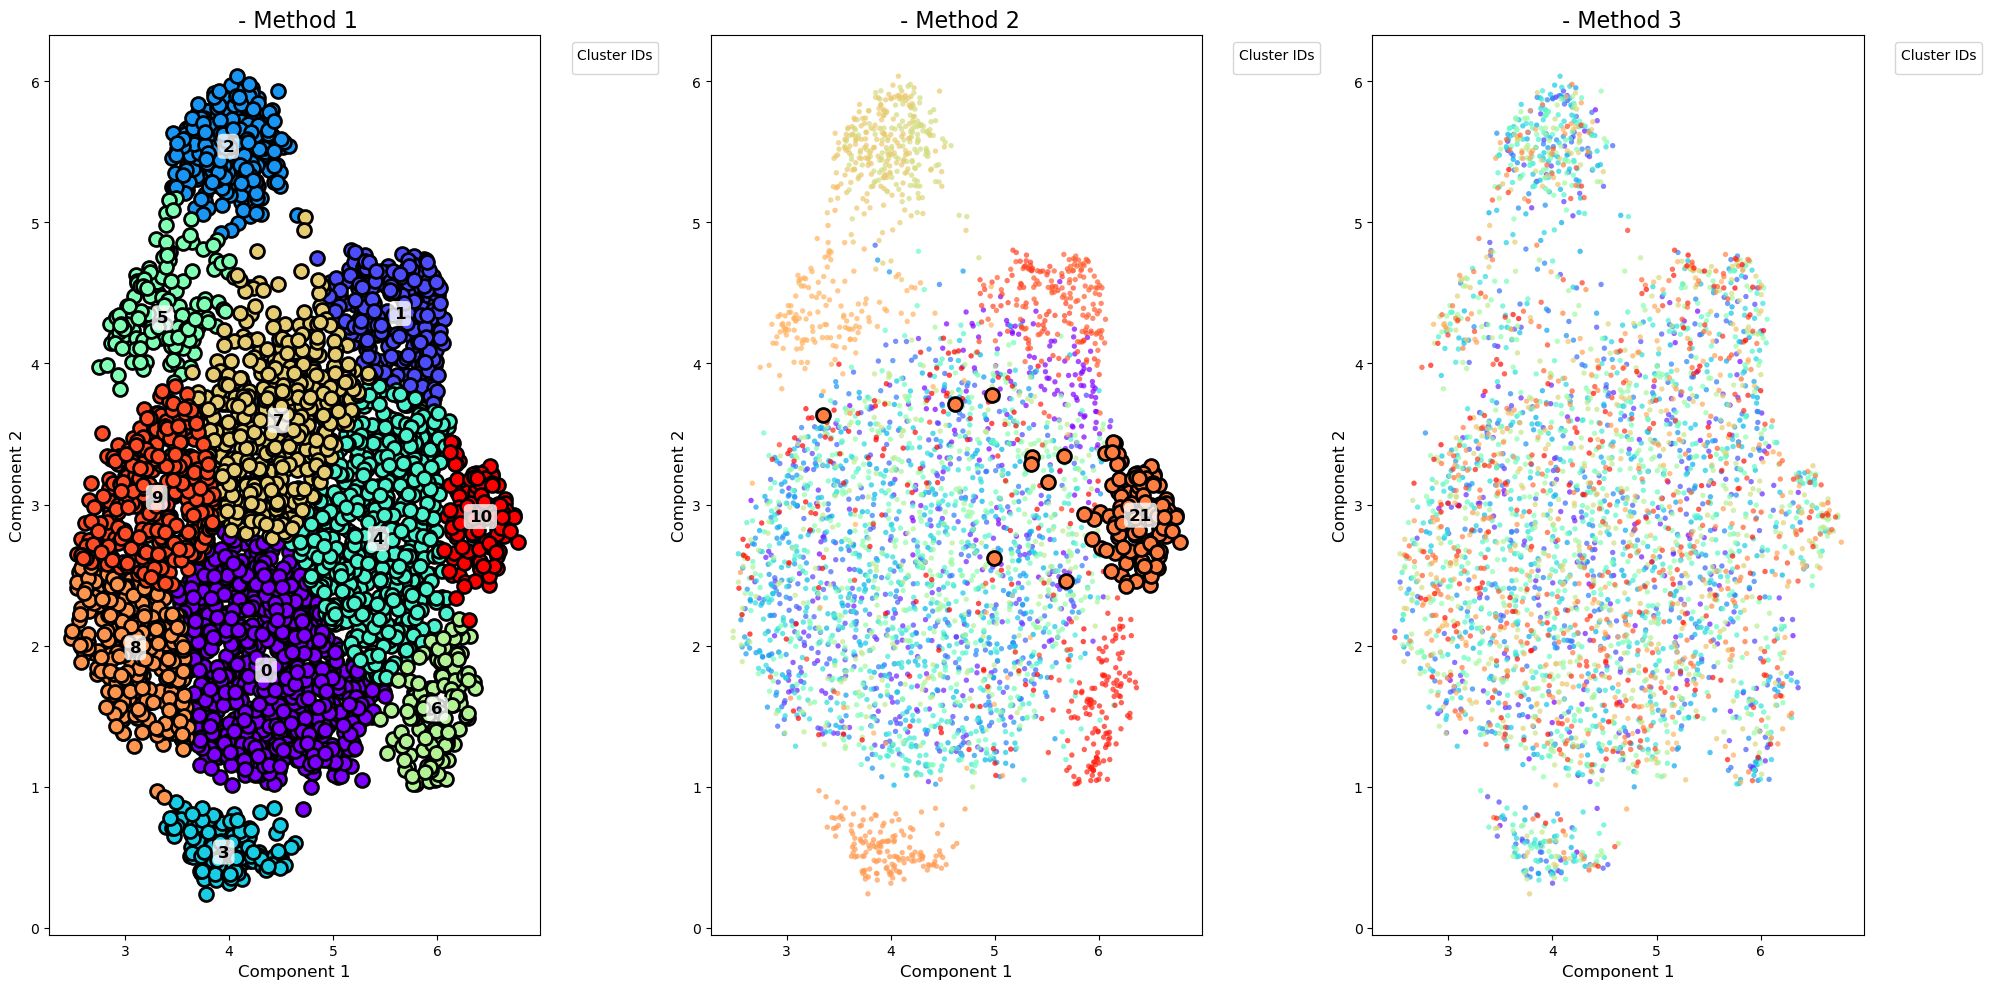

In [98]:
draw_cluster(np.array(umap_embeddings[best_umap]), c_maps = [kmeans_clusters.labels_, pop_per_sample, trait_c_scale],
             highlight_clusters = [np.unique(kmeans_clusters.labels_), [21], interesting_clusters_umap])

In [100]:
def draw_sil_per_sample(plot_data, clusters_labels, metrics=["euclidean"],
                        groups = None):
    n_metrics = len(metrics)
    fig, axs = plt.subplots(n_metrics, 1, figsize=(20, 8 * n_metrics))
    
    # Handle case with single metric
    if n_metrics == 1:
        axs = [axs]
    
    for ax, metric in zip(axs, metrics):
        sil_per_sample = sklearn.metrics.silhouette_samples(
            plot_data, clusters_labels, metric=metric
        )
        
        # Create violin plot
        sns.violinplot(x=clusters_labels, y=sil_per_sample, 
                       ax=ax, inner=None, linewidth=0.5)
        
        # Add beeswarm plot
        sns.swarmplot(x=clusters_labels, y=sil_per_sample, 
                     color='black', size=1, ax=ax, 
                     edgecolor='gray', linewidth=0.5, alpha=0.7)
        ax.hlines(y = 0, xmin = 0, xmax = len(np.unique(clusters_labels)), color = 'r', linestyle='--')
        ax.set_title(f'Silhouette Scores ({metric})')
        ax.set_xlabel('Population/Cluster')
        ax.set_ylabel('Silhouette Score')
        if groups is not None:
            new_x_ticks = []
            new_x_order = []
            for cur_group in groups.keys():
                new_x_ticks += [str(x) + f"\n({cur_group})" for x in groups[cur_group]]
                new_x_order += groups[cur_group]
            #new_x_ticks = np.array(new_x_ticks)[np.argsort(new_x_order)[::-1]]
            ax.set_xticks(ticks = np.array(new_x_order) - 1, labels = new_x_ticks)
        #ax.set_ylim(-1, 1)  # Silhouette score range
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_891/2883209797.py:20: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(x=clusters_labels, y=sil_per_sample,
/tmp/ipykernel_891/2883209797.py:20: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(x=clusters_labels, y=sil_per_sample,
/tmp/ipykernel_891/2883209797.py:20: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(x=clusters_labels, y=sil_per_sample,


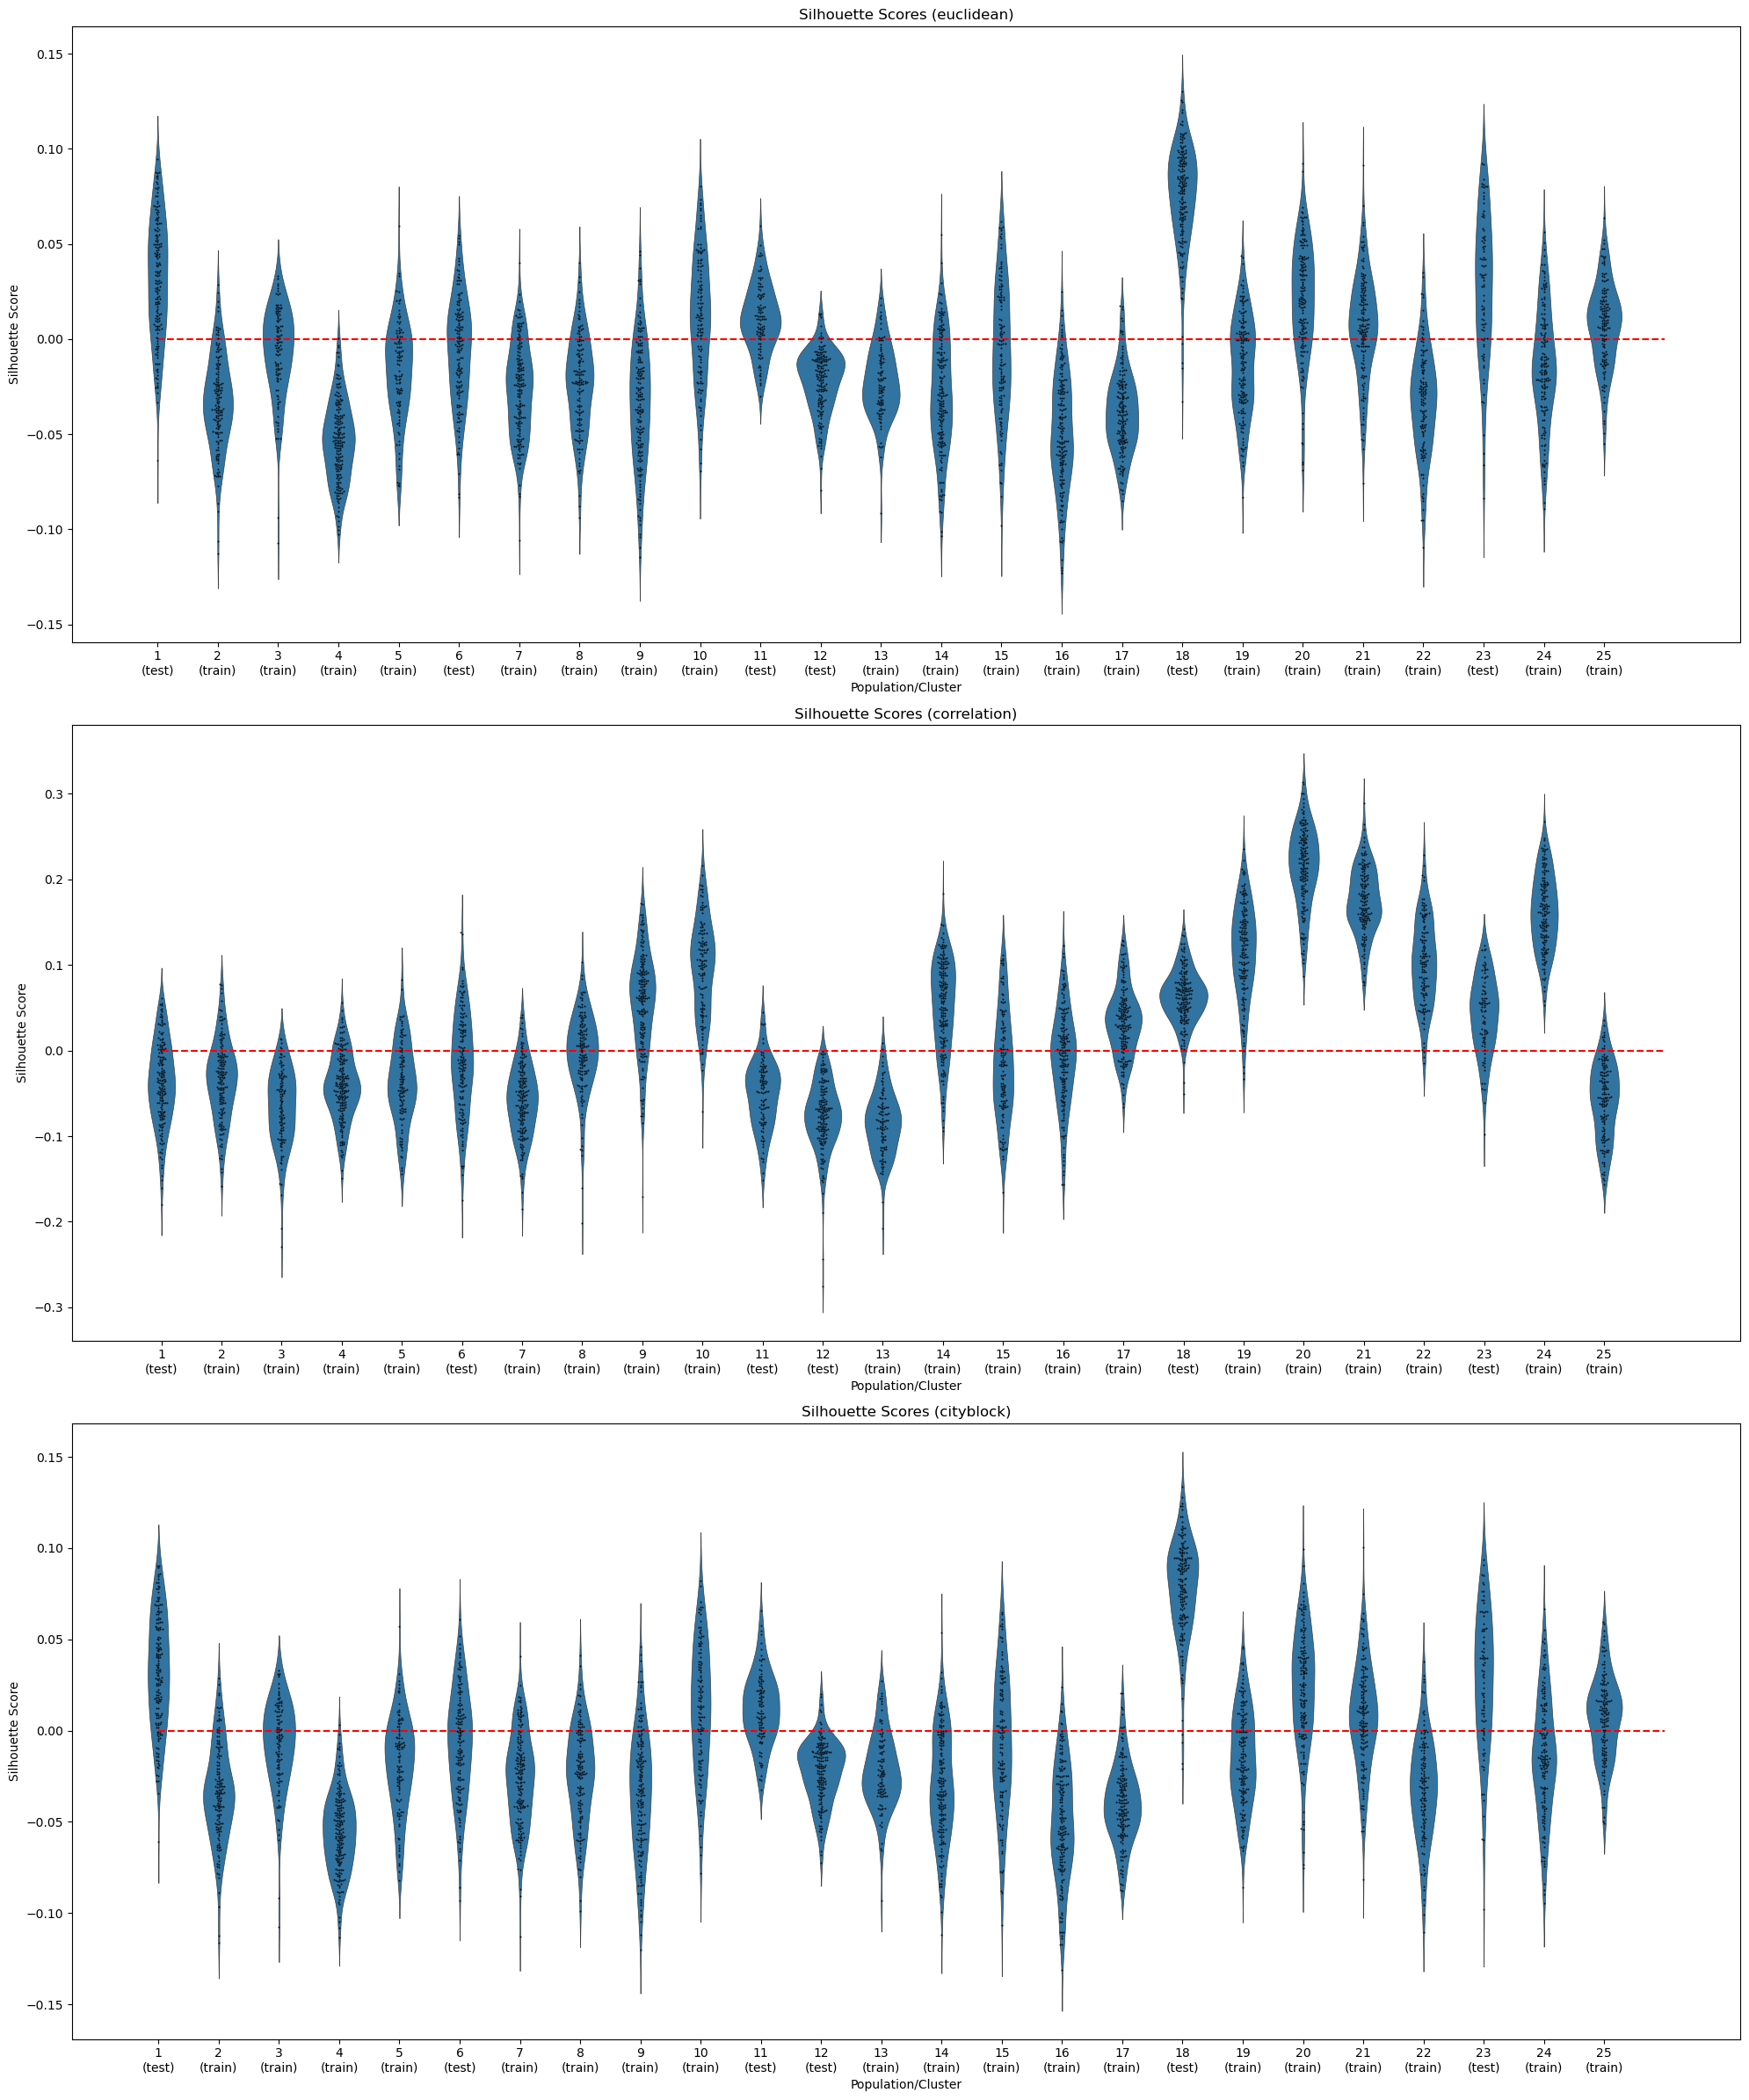

In [102]:
draw_sil_per_sample(full_embedding, pop_per_sample, metrics = ["euclidean", "correlation", "cityblock"],
                    groups = {"test": list(test_pop), "train": list(train_pop)})
# draw_sil_per_sample(umap_embeddings[best_umap], pop_per_sample, metrics = ["euclidean", "cityblock" ],
#                     groups = {"test": list(test_pop), "train": list(train_pop)})

# Pop analysis

In [ ]:
def apply_per_axis(func, axis, arr, **kwargs):
    n_slices = arr.shape[axis]
    out = []
    for cur_slice in range(n_slices):
        cur_arr = np.take(arr, cur_slice, axis = axis)
        out.append(func(cur_arr, kwargs))
    try:
        out = np.array(out)
    except:
        print("Output malformed, returning list")
    return out

In [119]:
sil_per_sample = sklearn.metrics.silhouette_samples(
    full_embedding, pop_per_sample, metric="euclidean"
)

In [128]:
pop_of_interest = 18
pop_idx = pop_per_sample.to_numpy() == pop_of_interest
pop_embeddings = full_embedding[pop_idx]
pop_genos = child_geno_data[pop_idx]

In [160]:
pop_sil = sil_per_sample[pop_per_sample == pop_of_interest]
pop_geno_counts = pop_genos.iloc[:, 2:-2].apply(pd.value_counts).fillna(0)
pop_geno_freqs = pop_geno_counts.apply(lambda col: col/sum(col))

/tmp/ipykernel_891/425565675.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pop_geno_counts = pop_genos.iloc[:, 2:-2].apply(pd.value_counts).fillna(0)
/tmp/ipykernel_891/425565675.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pop_geno_counts = pop_genos.iloc[:, 2:-2].apply(pd.value_counts).fillna(0)
/tmp/ipykernel_891/425565675.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pop_geno_counts = pop_genos.iloc[:, 2:-2].apply(pd.value_counts).fillna(0)
/tmp/ipykernel_891/425565675.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pop_geno_counts = pop_genos.iloc[:, 2:-2].apply(pd.value_counts).fillna(0)
/tmp/ipykernel_891/4

In [162]:
sil_per_sample

array([ 0.00100639, -0.00771253,  0.05710617, ...,  0.01313948,
        0.06387426,  0.00620482], dtype=float32)

In [161]:
pop_geno_freqs

PZA01271.1  PZA03613.1  PZA02129.1  PZA02032.1  PHM2244.142  PZA02372.1  \
--         0.0    0.053571         0.0    0.023810     0.059524    0.023810   
AA         0.0    0.369048         0.0    0.505952     0.000000    0.000000   
AC         0.0    0.000000         0.0    0.000000     0.000000    0.000000   
AG         0.0    0.000000         0.0    0.000000     0.000000    0.000000   
AT         0.0    0.035714         0.0    0.041667     0.000000    0.000000   
CC         1.0    0.000000         0.0    0.000000     0.940476    0.523810   
CG         0.0    0.000000         0.0    0.000000     0.000000    0.000000   
CT         0.0    0.000000         0.0    0.000000     0.000000    0.023810   
GG         0.0    0.000000         0.0    0.000000     0.000000    0.000000   
GT         0.0    0.000000         0.0    0.000000     0.000000    0.000000   
TT         0.0    0.541667         1.0    0.428571     0.000000    0.428571   

    PHM6238.36  PZA00181.2  PZA00528.1  PZA00175.2  ...  PZA02474.1  \
--    0.041667    0.005952    0.005952    0.041667  ...         0.0   
AA    0.458333    0.000000    0.994048    0.434524  ...         1.0   
AC    0.000000    0.000000    0.000000    0.000000  ...         0.0   
AG    0.053571    0.000000    0.000000    0.000000  ...         0.0   
AT    0.000000    0.000000    0.000000    0.035714  ...         0.0   
CC    0.000000    0.000000    0.000000    0.000000  ...         0.0   
CG    0.000000    0.000000    0.000000    0.000000  ...         0.0   
CT    0.000000    0.000000    0.000000    0.000000  ...         0.0   
GG    0.446429    0.994048    0.000000    0.000000  ...         0.0   
GT    0.000000    0.000000    0.000000    0.000000  ...         0.0   
TT    0.000000    0.000000    0.000000    0.488095  ...         0.0   

    PZA02528.1  PZA02862.3  PZA02984.10  PZA03036.6  PZA03048.18  PZA03317.1  \
--    0.035714    0.047619     0.011905    0.017857     0.000000         0.0   
AA    0.000000    0.000000     0.000000    0.000000     0.000000         1.0   
AC    0.000000    0.000000     0.000000    0.000000     0.000000         0.0   
AG    0.000000    0.000000     0.000000    0.000000     0.000000         0.0   
AT    0.000000    0.000000     0.000000    0.000000     0.005952         0.0   
CC    0.541667    0.404762     0.488095    0.500000     0.000000         0.0   
CG    0.041667    0.000000     0.000000    0.029762     0.000000         0.0   
CT    0.000000    0.023810     0.017857    0.000000     0.000000         0.0   
GG    0.380952    0.000000     0.000000    0.452381     0.000000         0.0   
GT    0.000000    0.000000     0.000000    0.000000     0.000000         0.0   
TT    0.000000    0.523810     0.482143    0.000000     0.994048         0.0   

    PZA03578.1  PZA03603.1  PZB01944.1  
--    0.047619    0.065476         0.0  
AA    0.404762    0.517857         1.0  
AC    0.000000    0.000000         0.0  
AG    0.035714    0.000000         0.0  
AT    0.000000    0.011905         0.0  
CC    0.000000    0.000000         0.0  
CG    0.000000    0.000000         0.0  
CT    0.000000    0.000000         0.0  
GG    0.511905    0.000000         0.0  
GT    0.000000    0.000000         0.0  
TT    0.000000    0.404762         0.0  

[11 rows x 1144 columns]

# Geno comparison

In [104]:
p2_is_interesting = np.array([cur_pop in interesting_clusters_umap for cur_pop in pop_per_sample])

In [106]:
p2_df = pd.DataFrame(p2_genos_np)
int_val_counts = p2_df.iloc[p2_is_interesting, :].apply(pd.value_counts).fillna(0)
int_val_freq = int_val_counts.apply(lambda col: col/sum(col))

bg_val_counts = p2_df.iloc[~p2_is_interesting, :].apply(pd.value_counts).fillna(0)
bg_val_freq = bg_val_counts.apply(lambda col: col/sum(col))

/tmp/ipykernel_891/1677895833.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  int_val_counts = p2_df.iloc[p2_is_interesting, :].apply(pd.value_counts).fillna(0)
/tmp/ipykernel_891/1677895833.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  int_val_counts = p2_df.iloc[p2_is_interesting, :].apply(pd.value_counts).fillna(0)
/tmp/ipykernel_891/1677895833.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  int_val_counts = p2_df.iloc[p2_is_interesting, :].apply(pd.value_counts).fillna(0)
/tmp/ipykernel_891/1677895833.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  int_val_counts = p2_df.iloc[p2_is_interesting, :].apply(pd.value_co

In [296]:
full_model_preds[1]

<tf.Tensor: shape=(3554, 1144, 11), dtype=float32, numpy=
array([[[ 0.4973472 , -5.714856  , -5.023822  , ...,  3.3894238 ,
         -5.4550614 , -4.915734  ],
        [-0.1932737 ,  2.8539424 , -5.190966  , ..., -4.5711317 ,
         -5.9574137 ,  2.7198946 ],
        [ 1.7347454 , -3.1451266 , -4.029348  , ..., -4.295132  ,
         -4.9331193 ,  4.4468136 ],
        ...,
        [ 3.0762107 , -0.04411073, -4.0659    , ...,  5.336574  ,
         -4.7320185 , -4.9323754 ],
        [ 0.14588547,  4.3763523 , -4.6650476 , ..., -4.753711  ,
         -5.947056  ,  1.5473223 ],
        [ 1.106467  ,  5.108714  , -3.1563244 , ...,  3.260482  ,
         -5.2383027 , -3.5606718 ]],

       [[-0.25098303, -5.731628  , -6.282797  , ...,  3.4905236 ,
         -4.8450265 , -5.0828385 ],
        [-0.25856632,  3.32725   , -6.3668833 , ..., -5.277818  ,
         -5.564657  ,  2.8610253 ],
        [ 1.5382383 , -3.3272412 , -5.1192994 , ..., -4.6253405 ,
         -4.5127516 ,  4.7126207 ],
        .

In [301]:
geno_pred_per_pop = [full_model_preds[1][pop_per_sample.to_numpy() == cur_pop] for cur_pop in np.unique(pop_per_sample)]
geno_truth_per_pop = [child_geno_tensor[pop_per_sample.to_numpy() == cur_pop] for cur_pop in np.unique(pop_per_sample)]

In [316]:
acc_per_pop = {}
for cur_pop in range(len(np.unique(pop_per_sample))):
    pop_id = np.unique(pop_per_sample)[cur_pop]
    pred_acc = tf.argmax(geno_pred_per_pop[cur_pop], axis = -1) == tf.argmax(geno_truth_per_pop[cur_pop], axis = -1)
    acc_per_pop[pop_id] = pred_acc.numpy().mean()

In [317]:
interesting_clusters_umap

[np.int64(18),
 np.int64(19),
 np.int64(20),
 np.int64(21),
 np.int64(22),
 np.int64(23),
 np.int64(24),
 np.int64(26)]

In [319]:
test_pop

array([ 1,  9, 10, 12, 24, 26])

In [318]:
acc_per_pop

{np.int64(1): np.float64(0.7623726582059915),
 np.int64(2): np.float64(0.8316894254394255),
 np.int64(3): np.float64(0.792407358996144),
 np.int64(4): np.float64(0.8318191639820853),
 np.int64(5): np.float64(0.8069570616299588),
 np.int64(6): np.float64(0.811543351753142),
 np.int64(7): np.float64(0.8225683407501589),
 np.int64(8): np.float64(0.8033346283346283),
 np.int64(9): np.float64(0.7746595509753404),
 np.int64(10): np.float64(0.7540455412356238),
 np.int64(11): np.float64(0.8129549022406165),
 np.int64(12): np.float64(0.7689596795609454),
 np.int64(13): np.float64(0.7979949737762237),
 np.int64(14): np.float64(0.8441622298156389),
 np.int64(15): np.float64(0.8157675657675658),
 np.int64(16): np.float64(0.8259972276244466),
 np.int64(18): np.float64(0.8499774765112188),
 np.int64(19): np.float64(0.8544944638694638),
 np.int64(20): np.float64(0.8439517213555675),
 np.int64(21): np.float64(0.8365664783934015),
 np.int64(22): np.float64(0.841789123039123),
 np.int64(23): np.float64

# Trait Clustering

In [9]:
pheno_per_pop =child_pheno_data.reset_index().loc[:, ["pop", "val_mean", "val_sd"]]

In [24]:
smallest_pop = min(pheno_per_pop.groupby("pop").size())

In [26]:
pop_samples = pheno_per_pop.groupby("pop").sample(smallest_pop)

In [ ]:
pop_samples.group

pop  val_mean    val_sd
55      1  4.114000  0.551480
78      1  3.730000  0.371304
59      1  3.864000  0.438725
51      1  4.058571  0.646437
65      1  3.390000  0.458094
...   ...       ...       ...
3435   26  4.114000  0.697374
3519   26  5.597500  0.673368
3537   26  5.245000  0.424111
3521   26  4.556000  0.720125
3454   26  4.304000  0.542245

[2150 rows x 3 columns]

In [ ]:
pop_pairs = list(itertools.combinations_with_replacement(np.unique(pop_samples["pop"]), 2))

In [51]:
p1_partner = [pop_pairs[cur_pair][0] for cur_pair in range(len(pop_pairs))]
p2_partner = [pop_pairs[cur_pair][1] for cur_pair in range(len(pop_pairs))]

In [52]:
def pop_dist(pop_pair, data):
    pop1 = data[data["pop"] == pop_pair[0]]
    pop2 = data[data["pop"] == pop_pair[1]]
    pair_distances = metrics.pairwise_distances(pop1[["val_mean", "val_sd"]], pop2[["val_mean", "val_sd"]])
    return np.mean(pair_distances)

In [53]:
pair_dists = [pop_dist(cur_pair, pop_samples) for cur_pair in pop_pairs]


In [70]:
pair_dists_df = pd.DataFrame({"dist": pair_dists, "p1": p1_partner, "p2": p2_partner})
pair_dists_df = pair_dists_df.loc[pair_dists_df["p1"] != pair_dists_df["p2"], :]

In [72]:
pair_dists_df.to_csv("pairwise_dist_oil.csv")